# Multi-class Classification
To use logistic regression to recognize handwritten digits (from 0 to 9). Using regularized logistic regression and apply it to one-vs-all classificaiton.

## Dataset
The dataset for the exercise was originally comes in .mat file which I use Octave to export it to a csv file. 

There are 5,000 training examples of handwritten digits, where each traininig example is a 20 by 20 pixel grayscale image of the digit. Each pixel is represented by a floating point number indicating the grayscale intensity at the location. The 20 by 20 grid of pixels is unrolled into a 400-dimensional vector. Each of these training examples becomes a single row in our data matrix X.

There is also 5000-dimensional vector y that contains labels for the training set. Note that 0 is represented as 10 to avoid confusion with MATLAB/Octave indexing system at 1, while the digits 1 to 9 are labeled as 1 to 9 in their natural order.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io

In [2]:
mat = scipy.io.loadmat('datasets/ex3data1.mat')
X, y = mat['X'], mat['y']
print('X shape: {}'.format(X.shape))
print('y shape: {}'.format(y.shape))

X shape: (5000, 400)
y shape: (5000, 1)


In [3]:
mat = scipy.io.loadmat('datasets/ex3weights.mat')
Theta1, Theta2 = mat['Theta1'], mat['Theta2']

print('Theta1 shape: {}'.format(Theta1.shape))
print('Theta2 shape: {}'.format(Theta2.shape))

Theta1 shape: (25, 401)
Theta2 shape: (10, 26)


## EDA

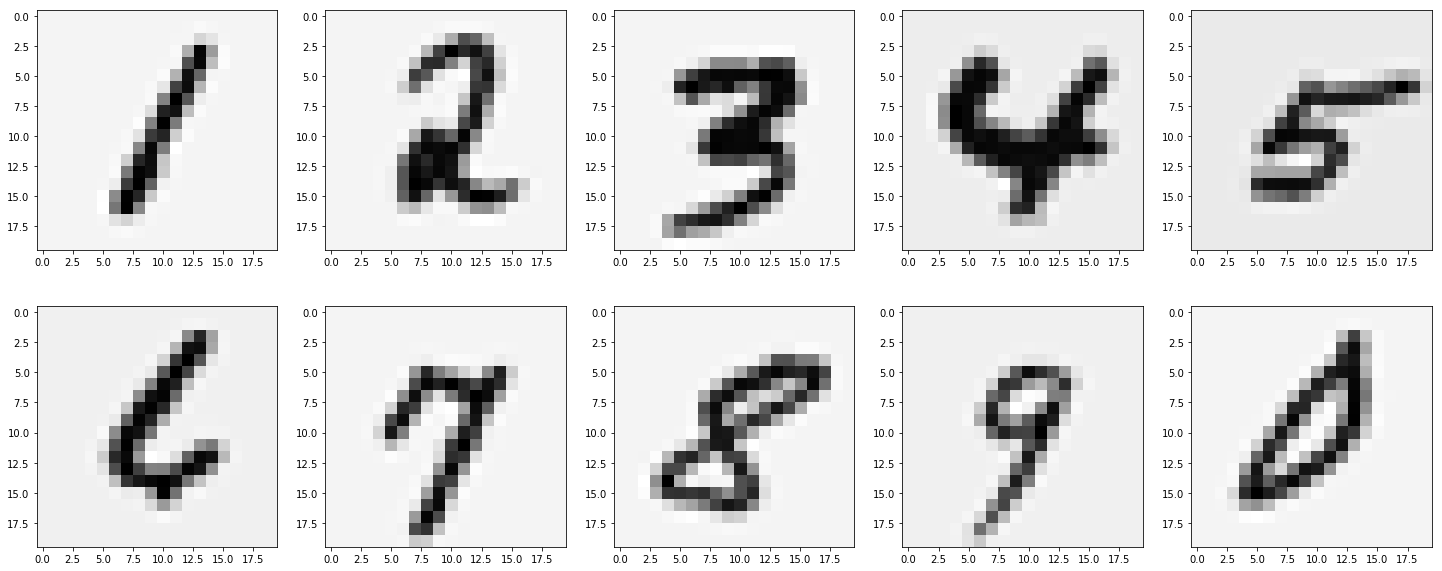

In [4]:
# randomly pick index of image samples for 0-9 each (label 1-10) 
image_idx = [ np.random.choice(np.where(y==i)[0]) for i in np.arange(1,11) ]

# Plot an example for each label
fig, axes = plt.subplots(2, 5,figsize=(25,10))
for i in np.arange(2):
    for j in np.arange(5):
        im = X[image_idx[5*i+j],:].reshape(-20,20, order='F')
        axes[i,j].imshow(im, cmap=plt.cm.gray_r)

## Logistic Regression Cost function (regularized)
Use the same code as in the previous exercise.

In [5]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))

def costFunctionReg(theta, X, y, l):
    m = len(y)
    theta = theta.reshape(-1,1)
    
    # compute hypothesis h(x)
    h = sigmoid(X @ theta)
    
    # theta 0 is not regularized
    J = -1/m * np.sum(y*np.log(h) + (1-y)*np.log(1-h)) \
        + l/(2*m) * np.sum(theta[1:]**2)
        
    return J

def gradientFunctionReg(theta, X, y, l):
    m = len(y)
    theta = theta.reshape(-1,1)
    
    # compute hypothesis h(x)
    h = sigmoid(X @ theta)
    
    grad = np.zeros((X.shape[1], 1))
    # compute gradient for theta 0 (not regularized)
    grad[0,0] = 1/m * np.sum(h - y)

    # compute gradients (theta_0, ... theta_n)
    grad[1:] = (np.transpose(X[:,1:]) @ (h-y))/m + (l/m * theta[1:])
    
    return grad.flatten()

#### Testing Cost Function

In [6]:
theta_t = np.array([-2, -1, 1, 2])
X_t = np.append(np.ones((5,1)),np.arange(1,16).reshape(5,3,order='F')/10,axis=1)
y_t = np.array([1,0,1,0,1]).reshape(-1,1)
lambda_t = 3

cost = costFunctionReg(theta_t, X_t, y_t, lambda_t)
grad = gradientFunctionReg(theta_t, X_t, y_t, lambda_t)

print('Cost: {}'.format(cost))
print('Expected cost: 2.534819')
print('Gradients:\n{}'.format(grad))
print('Expected gradients:\n[ 0.146561  -0.548558  0.724722  1.398003]')

Cost: 2.534819396109744
Expected cost: 2.534819
Gradients:
[ 0.14656137 -0.54855841  0.72472227  1.39800296]
Expected gradients:
[ 0.146561  -0.548558  0.724722  1.398003]


## One-vs-all Classification
To train multiple regularized logistic regression classifiers, one for each of the K (=10) classes in the dataset. The matrix $\Theta \in \mathbb{R}^{K*(N+1)}$, where each row of $\Theta$ corresponds to the learned logistic regression parameters for one class.

In [7]:
m,n = X.shape
num_labels = 10

all_theta = np.zeros((num_labels, n+1))

# Add ones to the X data matrix
X = np.append(np.ones((m,1)), X, axis=1)

# Initial theta
initial_theta = np.zeros(n+1)

### Optimizing for all classifiers

In [8]:
from scipy.optimize import minimize, fmin_cg

l = 0.1
# for c in np.arange(1, num_labels+1):
#     result = minimize(fun = costFunctionReg,
#                      x0 = initial_theta,
#                      args = (X, (y == c), l),
#                      method = 'CG',
#                      jac = gradientFunctionReg),
#                     options={'maxiter':50})
#     all_theta[c - 1,:] = result.x
    
for c in np.arange(1, num_labels+1):
    print('Optimizing class: {}...'.format(c))
    result = fmin_cg(f = costFunctionReg,
                     x0 = initial_theta,
                     args = (X, (y == c), l),
                     fprime = gradientFunctionReg)
    all_theta[c - 1,:] = result

Optimizing class: 1...
Optimization terminated successfully.
         Current function value: 0.013117
         Iterations: 128
         Function evaluations: 494
         Gradient evaluations: 494
Optimizing class: 2...
Optimization terminated successfully.
         Current function value: 0.050815
         Iterations: 280
         Function evaluations: 854
         Gradient evaluations: 854
Optimizing class: 3...
Optimization terminated successfully.
         Current function value: 0.057610
         Iterations: 218
         Function evaluations: 642
         Gradient evaluations: 642
Optimizing class: 4...
Optimization terminated successfully.
         Current function value: 0.033076
         Iterations: 184
         Function evaluations: 602
         Gradient evaluations: 602
Optimizing class: 5...
Optimization terminated successfully.
         Current function value: 0.054465
         Iterations: 222
         Function evaluations: 651
         Gradient evaluations: 651
Optimizing

### Predict
Use the max probability

In [9]:
pred = np.argmax(sigmoid(X @ np.transpose(all_theta)), axis=1) + 1
print('Training accuracy: {}'.format(np.mean(pred == y.flatten())))

Training accuracy: 0.9646
